# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
!ls "/content/drive/"

'My Drive'


In [0]:
project_path = "/content/drive/My Drive/Content/ExternalLab"

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
import os
os.chdir('/content/drive/My Drive/Content/ExternalLab')

In [0]:
!mkdir trainDirectory

In [0]:
#%cd trainDirectory
!pwd

/content/drive/My Drive/Content/ExternalLab


In [0]:
!ls "/content/drive/My Drive/Content/ExternalLab"

data.zip  R9_External_Lab_Questions.ipynb  train  trainDirectory  train.zip


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + '/train.zip', 'r') as zf:
  zf.extractall('trainDirectory/')


In [0]:
#The train file have both images and masks with the same names_ids.

In [0]:
!unzip train.zip -d trainDirectory

Archive:  train.zip
replace trainDirectory/images/8d08955cdf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: trainDirectory/images/8d08955cdf.png  
replace trainDirectory/images/e045664b46.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: trainDirectory/images/e045664b46.png  
  inflating: trainDirectory/images/4989c6509e.png  
  inflating: trainDirectory/images/fff4eb4941.png  
  inflating: trainDirectory/images/3a310860a3.png  
  inflating: trainDirectory/images/7a696bb878.png  
  inflating: trainDirectory/images/8d3ee9356b.png  
  inflating: trainDirectory/images/213e0a9f7b.png  
  inflating: trainDirectory/images/78f17697f2.png  
  inflating: trainDirectory/images/bd20d18369.png  
  inflating: trainDirectory/images/de08c5a3b7.png  
  inflating: trainDirectory/images/f06ef6c8b7.png  
  inflating: trainDirectory/images/b2d02516e1.png  
  inflating: trainDirectory/images/5edb37f5a8.png  
  inflating: trainDirectory/images/b1f0e104f5.png  
  inflating: trainDirectory/

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
os.listdir()

['R9_External_Lab_Questions.ipynb',
 'train.zip',
 'data.zip',
 'trainDirectory',
 'train']

In [0]:
imagelist1 = []
masklist1 = []

In [0]:
for file in os.listdir("/content/drive/My Drive/Content/ExternalLab/train/images"):
  imagelist1.append(file)

In [0]:
for file in os.listdir("/content/drive/My Drive/Content/ExternalLab/train/masks"):
  masklist1.append(file)

In [0]:
len(imagelist)

4000

In [0]:
len(masklist)

4000

In [0]:
#Test your list names by printing some of the names as given below.
print(imagelist1[-1])
print(masklist1[-1])
print(imagelist1[9])
print(masklist1[9])

9ae45b19d3.png
9ae45b19d3.png
b70f0ab0c2.png
b70f0ab0c2.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import matplotlib.pyplot as plt

import cv2

In [0]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [0]:
images = load_images_from_folder('/content/drive/My Drive/Content/ExternalLab/train/images/')

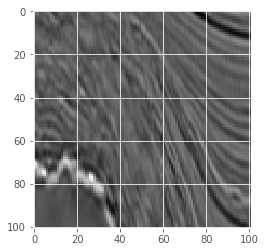

In [0]:
plt.imshow(images[2000])

In [0]:
masks = load_images_from_folder('/content/drive/My Drive/Content/ExternalLab/train/masks/')

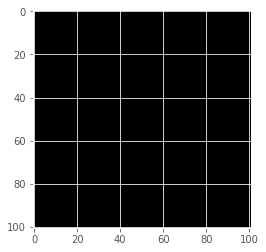

In [46]:
plt.imshow(masks[100])

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
project_path

'/content/drive/My Drive/Content/ExternalLab'

In [0]:
# Get and resize train images and masks
def get_data(train=True):
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path = os.path.join(project_path +'/train/images/' +n ) #/*** Add your code here***/
        ##Add mask_path
        mask_path =  os.path.join(project_path +'/train/masks/' +n )                                                          
        
        # Load images and resize to (128,128,1)
       # /*** Add your code here***/
        img = load_img(image_path)
        resized_img = img_to_array(img)
        resized_img = resize(resized_img, (128, 128, 1), mode='constant', preserve_range=True)     
        # Load masks and resize to (128,128,1)
        #/*** Add your code here***/
        resized_mask = img_to_array(load_img(mask_path))
        resized_mask = resize(resized_mask, (128, 128, 1), mode='constant', preserve_range=True)
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

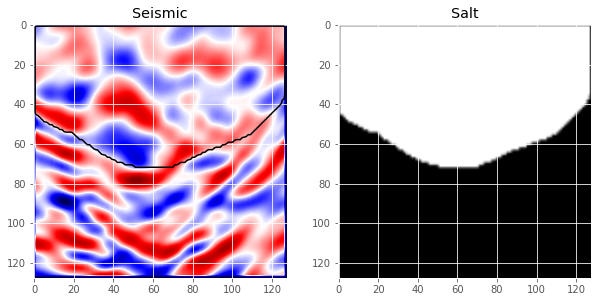

In [0]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
  # first layer
  x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
  padding="same")(input_tensor)
  if batchnorm:
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
  # second layer
  x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
  padding="same")(x)
  if batchnorm:
     x = BatchNormalization()(x)
     x = Activation("relu")(x)
  return x
   

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
  # contracting path
  c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p1 = MaxPooling2D((2, 2)) (c1)
  p1 = Dropout(dropout*0.5)(p1)
  c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
  p2 = MaxPooling2D((2, 2)) (c2)
  p2 = Dropout(dropout)(p2)
  c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
  p3 = MaxPooling2D((2, 2)) (c3)
  p3 = Dropout(dropout)(p3)
  c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
  p4 = Dropout(dropout)(p4)
  c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
  # expansive path
  u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
  u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
  u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
  u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [42]:
results = model.fit(X_train, y_train, batch_size=32, epochs=5,
validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 3400 samples, validate on 600 samples
Epoch 1/5
3400/3400 [==============================] - 1009s 297ms/step - loss: 0.4096 - acc: 0.8321 - val_loss: 0.4708 - val_acc: 0.8641
Epoch 2/5
3400/3400 [==============================] - 1030s 303ms/step - loss: 0.3029 - acc: 0.8817 - val_loss: 0.4160 - val_acc: 0.8776
Epoch 3/5
3400/3400 [==============================] - 1028s 302ms/step - loss: 0.2637 - acc: 0.8975 - val_loss: 0.3070 - val_acc: 0.8847
Epoch 4/5
3400/3400 [==============================] - 993s 292ms/step - loss: 0.2514 - acc: 0.9010 - val_loss: 0.9327 - val_acc: 0.7823
Epoch 5/5
3400/3400 [==============================] - 1032s 304ms/step - loss: 0.2301 - acc: 0.9097 - val_loss: 0.2541 - val_acc: 0.9040


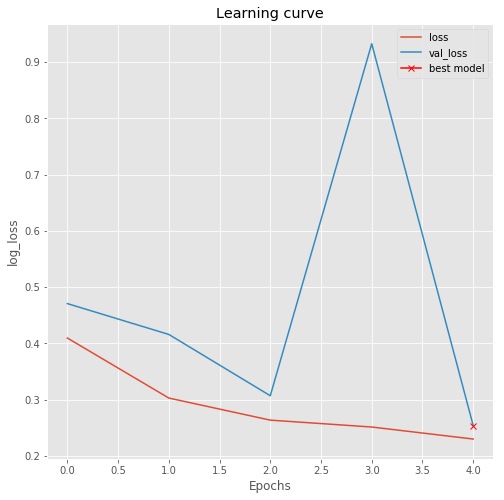

In [43]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### 8. Define loss and dice_coeff function.

In [0]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [0]:
def dice_coef_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [48]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-k3qblisi
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-k3qblisi
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 81kB 3.8MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-6bsiu1_5/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
import segmentation_models

In [0]:
model1 = segmentation_models.Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(im_height, im_width, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

model1.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])


In [55]:
#Get the summary of your model
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   3136        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [56]:
results = model1.fit(X_train, y_train, batch_size=32, epochs=3,
validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/3
3400/3400 [==============================] - 1656s 487ms/step - loss: 0.4402 - acc: 0.7974 - val_loss: 0.7696 - val_acc: 0.7613
Epoch 2/3
3400/3400 [==============================] - 1640s 482ms/step - loss: 0.3287 - acc: 0.8672 - val_loss: 0.4068 - val_acc: 0.8625
Epoch 3/3
3400/3400 [==============================] - 1636s 481ms/step - loss: 0.2910 - acc: 0.8832 - val_loss: 0.5709 - val_acc: 0.8301


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [0]:
preds_val = model.predict(np.array(X_valid))

In [60]:
preds_val[:5]

array([[[[1.63949430e-02],
         [1.32516325e-02],
         [3.23012471e-03],
         ...,
         [2.78040767e-03],
         [1.75522864e-02],
         [6.58476353e-03]],

        [[2.26899981e-03],
         [2.28300095e-02],
         [1.34529173e-02],
         ...,
         [5.31686246e-02],
         [5.23287356e-02],
         [8.65700841e-03]],

        [[1.13999844e-03],
         [8.46576691e-03],
         [1.27714574e-02],
         ...,
         [7.54031539e-02],
         [1.24059886e-01],
         [3.59061360e-03]],

        ...,

        [[3.98027897e-03],
         [2.09841430e-02],
         [1.92482769e-02],
         ...,
         [4.16442156e-02],
         [1.14729017e-01],
         [1.74665451e-03]],

        [[5.79294562e-03],
         [2.43594944e-02],
         [1.46954954e-02],
         ...,
         [7.26374984e-02],
         [8.95908773e-02],
         [3.71652842e-03]],

        [[1.31168067e-02],
         [1.69542134e-02],
         [8.58855247e-03],
         ...,
 

In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

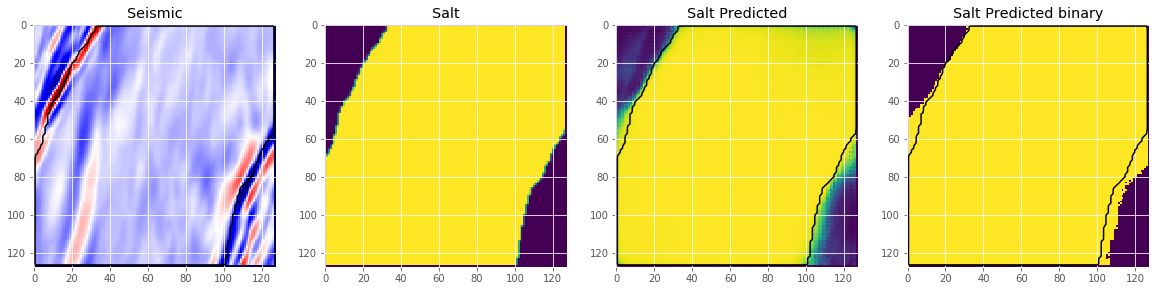

In [63]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [4]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Import Keras and other libraries

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import numpy as np
import os

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + '/data.zip', 'r') as zf:
  zf.extractall('data/')


In [0]:
filelist = []

In [0]:
for file in os.listdir("/content/drive/My Drive/Content/ExternalLab/data/"):
  filelist.append(file)

In [0]:
insideDataList=[]

In [0]:
for file in os.listdir("/content/drive/My Drive/Content/ExternalLab/data/data/"):
  insideDataList.append(file)

In [10]:
len(insideDataList)

31

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
for i in insideDataList:
  fileContent = open("/content/drive/My Drive/Content/ExternalLab/data/data/"+i).readlines()

In [25]:
codetext = []
bookranges = []
for files in insideDataList:
    text = open("/content/drive/My Drive/Content/ExternalLab/data/data/"+files, "r")
    print("Loading file " + files)
    start = len(codetext)
    codetext.append(text.read())
    end = len(codetext)
    bookranges.append({"start": start, "end": end, "name": files.rsplit("/", 1)[-1]})
    text.close()

Loading file For Love of the King.txt
Loading file Salomé A tragedy in one act.txt
Loading file Impressions of America.txt
Loading file The Canterville Ghost.txt
Loading file A House of Pomegranates.txt
Loading file Miscellaneous Aphorisms_ The Soul of Man.txt
Loading file A Woman of No Importance a play.txt
Loading file Essays and Lectures.txt
Loading file The Happy Prince and other tales.txt
Loading file Rose Leaf and Apple Leaf.txt
Loading file Vera or, The Nihilists.txt
Loading file Lord Arthur Savile_s Crime.txt
Loading file Poems with the Ballad of Reading Gaol.txt
Loading file Selected poems of oscar wilde including The Ballad of Reading Gaol.txt
Loading file Charmides and Other Poems.txt
Loading file An Ideal Husband.txt
Loading file The Duchess of Padua.txt
Loading file Oscar Wilde Miscellaneous.txt
Loading file The Ballad of Reading Gaol.txt
Loading file Shorter Prose Pieces.txt
Loading file Children in Prison and Other Cruelties of Prison Life.txt
Loading file Reviews.txt
L

In [26]:
len(codetext)

31

## Process the text
Initialize and fit the tokenizer

In [0]:
from keras.preprocessing.text import Tokenizer

In [0]:

tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word
word_counts = tokenizer.word_counts

Get the word count for every word and also get the total number of words.

In [29]:
len(idx_word.keys())

32838

In [30]:
num_words = len(word_idx) + 1
print ("Total no.of words = %d" %(num_words))

Total no.of words = 32839


Convert text to sequence of numbers

In [31]:
sequences = tokenizer.texts_to_sequences(codetext)
len(sequences)

31

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]
        
        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

In [33]:
features[0]

[3244, 52, 47, 365, 14, 96, 2, 1, 372, 26, 656, 474, 27, 365, 7, 14, 1, 162, 2]

In [34]:
labels[0]

624

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [36]:
for i, sequence in enumerate(X_train[:2]):
    text = []
#     print i, sequence
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: room in algernon's flat in half moon street the room is luxuriously and artistically furnished the sound of a

Label: piano

Features: a woman of no importance a play author oscar wilde release date september 16 2014 ebook 854 this file

Label: was



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [0]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [38]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3283900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32839)             2134535   
Total params: 5,464,835
Trainable params: 5,464,835
Non-trainable params: 0
___________

In [39]:
h = model.fit(X_train, y_train, epochs = 20, batch_size = 2000, 
          validation_data = (X_valid, y_valid), 
          verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 6510 samples, validate on 2790 samples
Epoch 1/20
6510/6510 [==============================] - 18s 3ms/step - loss: 10.3979 - acc: 0.0026 - val_loss: 10.3935 - val_acc: 0.0294
Epoch 2/20
6510/6510 [==============================] - 15s 2ms/step - loss: 10.3899 - acc: 0.0286 - val_loss: 10.3846 - val_acc: 0.0197
Epoch 3/20
6510/6510 [==============================] - 15s 2ms/step - loss: 10.3777 - acc: 0.0304 - val_loss: 10.3679 - val_acc: 0.0194
Epoch 4/20
6510/6510 [==============================] - 15s 2ms/step - loss: 10.3531 - acc: 0.0283 - val_loss: 10.3268 - val_acc: 0.0194
Epoch 5/20
6510/6510 [==============================] - 15s 2ms/step - loss: 10.2863 - acc: 0.0261 - val_loss: 10.1961 - val_acc: 0.0194
Epoch 6/20
6510/6510 [==============================] - 14s 2ms/step - loss: 10.0604 - acc: 0.0238 - val_loss: 9.7218 - val_acc: 0.0194
Epoch 7/20
6510/6510 [==============================] - 14s 2ms/step - loss: 9.3344

### Save Model

## If you have already trained the model and saved it, you can load a pretrained model

### Note: After loading the model run  model.fit()  to continue training form there, if required.

## Evaluation

In [40]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

6510/6510 [==============================] - 6s 954us/step
[6.161089598308511, 0.061290323837286866]

Model Performance: Log Loss and Accuracy on validation data
2790/2790 [==============================] - 3s 937us/step
[7.538083702005366, 0.0659498222252374]


## Generate text

In [42]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print(' '.join(original_sequence))
print("\n")
# print gen_list
print(' '.join(gen_list[0][1:]))
# print a

large stone lions the houses on each aide of the stage have coloured awnings from their windows and are flanked by stone arcades on the right of the stage is the public fountain with a triton in green bronze blowing from a conch around the fountain is a stone seat


using or lucas the editor the anyone milk at fourth gutenberg under victory read a character parts selection pglaf is on at of venture of world translate chancellor’s author pglaf after transcribed co a is re included whatsoever apple intentions that and in or from wilde on j and oscar
